<a href="https://colab.research.google.com/github/Vsantsaran/Vsantsaran/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Titanic Dataset
Source: https://www.kaggle.com/competitions/titanic/data

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

<ipython-input-210-757e28a6e4f7>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='YlGnBu')


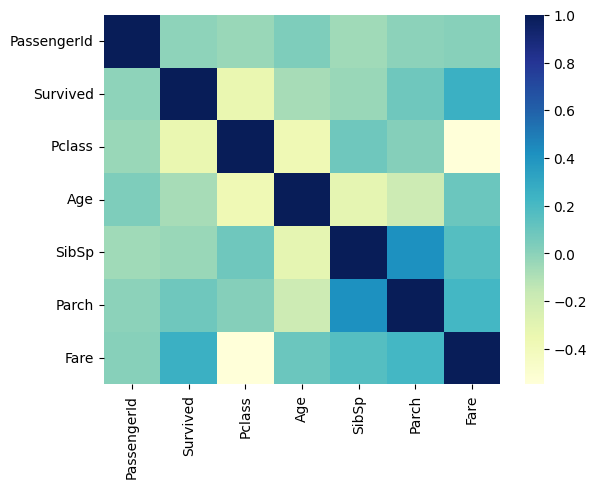

In [210]:
df_test = pd.read_csv("Titanic_test.csv")
df = pd.read_csv("Titanic_train.csv")

sns.heatmap(df.corr(), cmap='YlGnBu')
plt.show()
# Embarked: The port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).


In [162]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices, test_indices in split.split(df, df[['Survived', 'Pclass', 'Sex']]):
    strat_train_set = df.loc[train_indices]
    strat_test_set = df.loc[test_indices]

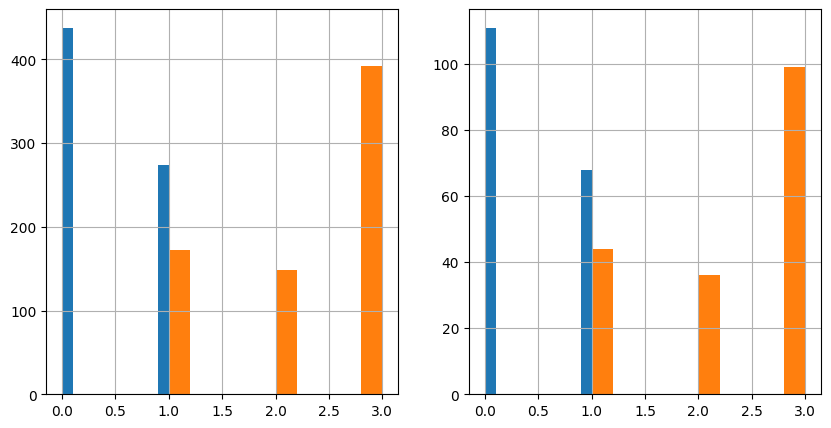

In [163]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1, 2, 2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()


##Creating custom transformers and encoders

In [164]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    # df_train.fill_na(df_train['Age'].mean())
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [165]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        col_names = ['S', 'C', 'Q', 'N']

        for i in range(len(matrix.T)):
            X[col_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        col_names = ['Female', 'Male']

        for i in range(len(matrix.T)):
            X[col_names[i]] = matrix.T[i]

        return X

In [166]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(['Embarked', 'Sex', 'Cabin', 'Name', 'Ticket', 'N'], axis=1, errors='ignore')

##Creating the pipeline

In [167]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('ageImputer', AgeImputer()),
    ('featureEncoder', FeatureEncoder()),
    ('featureDropper', FeatureDropper())
])

In [168]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [169]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,S,C,Q,Female,Male
867,868,0,1,31.0,0,0,50.4958,0.0,0.0,1.0,0.0,1.0
619,620,0,2,26.0,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
50,51,0,3,7.0,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
286,287,1,3,30.0,0,0,9.5000,0.0,0.0,1.0,0.0,1.0
834,835,0,3,18.0,0,0,8.3000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,0,3,50.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
518,519,1,2,36.0,1,0,26.0000,0.0,0.0,1.0,1.0,0.0
54,55,0,1,65.0,0,1,61.9792,1.0,0.0,0.0,0.0,1.0
603,604,0,3,44.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [170]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier()
param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000], 'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 3, 4, 6]}
]

grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10, 20],
                          'min_samples_split': [2, 3, 4, 6],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [172]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(min_samples_split=3, n_estimators=200)

In [173]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [174]:
scaler = StandardScaler()

X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set.Survived

X_test = scaler.fit_transform(X_test)
y_test = y_test.to_numpy()

In [175]:
final_clf.score(X_test, y_test)

0.8212290502793296

In [176]:
final_df = pipeline.fit_transform(df)

In [177]:
final_df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,S,C,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [190]:
X_test_final = final_df.drop(['Survived'], axis=1)
y_test_final = final_df.Survived

scaler = StandardScaler()
X_test_final = scaler.fit_transform(X_test_final)
y_test_final = y_test_final.to_numpy()

In [179]:
prod_clf = RandomForestClassifier()
param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000], 'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 3, 4, 6]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_test_final, y_test_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10, 20],
                          'min_samples_split': [2, 3, 4, 6],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [192]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=1000)

In [211]:
# Do not run this cell again. If u run this then u will face an errr and u'll have to reload the second cell of the programm.
df_test = pipeline.fit_transform(df_test)
df_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,S,C,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [194]:
final_X_dat = df_test
final_X_dat = final_X_dat.fillna(method='ffill')

scaler = StandardScaler()
final_X_dat = scaler.fit_transform(final_X_dat)

In [195]:
pred = final_clf.predict(final_X_dat)

In [219]:
DF = pd.DataFrame(df_test['PassengerId'])
DF['Survived'] = pred
path = 'D:\Maths\predictions.csv'
DF.to_csv(path, index=False)

In [220]:
pred_df = pd.read_csv('predictions.csv')
pred_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
